# 2.2 Transforming DataSources into Datasets
“It is a capital mistake to theorize before one has data.” Sherlock Holmes, “A Study in Scarlett” (Arthur Conan Doyle).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from src.logging import logger
logger.setLevel(logging.INFO)

## Turning a `DataSource` into a `Dataset`

### The Dataset object

A Dataset is the fundamental object we use for making the "munge" part of our data flow reproducible

What's a Dataset object? It's a scikit-learn-style Bunch, containing:

    data: the processed data
    target: (optional) target vector (for supervised learning problems)
    metadata: Data about the data

Under the hood, this is esentially a dictionary, with a little bit of magic to make it nicer to work with.


How do we turn raw data sources into something useful? There are 2 steps:
1. Write a function to extract meaningful `data` (and optionally, `target`) objects from your raw source files, that is, a **parse function**, and
2. package this **parse function** according to a very simple API


First, let's grab the `DataSource` we created in the last notebook.

### Loading a `DataSource` from the Catalog

In [3]:
from src import workflow
from src import paths
from src.data import DataSource
import pathlib

In [4]:
workflow.available_datasources()

['fmnist', 'lvq-pak']

In [5]:
dsrc = DataSource.from_name('lvq-pak')    # load it from the catalog
unpack_dir = dsrc.unpack()                # Find the location of the unpacked files

In [6]:
!ls -la $unpack_dir

total 24
drwxrwxr-x 3 amelie amelie 4096 août  30 17:37 .
drwxrwxr-x 4 amelie amelie 4096 août  30 17:38 ..
drwxr-xr-x 2 amelie amelie 4096 avril  7  1995 lvq_pak-3.1
-rw-rw-r-- 1 amelie amelie 2483 sept.  5 10:57 lvq-pak.license
-rw-rw-r-- 1 amelie amelie 4958 sept.  5 10:57 lvq-pak.readme


### Building a `Dataset` object

A `Dataset` is the fundamental object we use for making the "munge" part of our data flow reproducible

What's a Dataset object? It's a scikit-learn-style Bunch, containing:

    data: the processed data
    target: (optional) target vector (for supervised learning problems)
    metadata: Data about the data

Under the hood, this is esentially a dictionary, with a little bit of magic to make it nicer to work with.

Lucky for us, we can pick up from where we were at with our `DataSource`, and simply use the a parse function to turn it into a `Dataset`.

## Processing the data

The next step is to write the importer that actually processes the data we will be using for this dataset.

The important things to generate are `data` and `target` entries. A `metadata` is optional, but recommended if you want to save additional information about the dataset.

### `parse_function` Template
A **parse function** is a function that conforms to a very simple API: given some input, it returns a triple

```(data, target, additional_metadata)```


where `data` and `target` are in a format ingestible by, say, an sklearn pipeline.
`additional_metadata` is a dictionary of key-value pairs that will be added to any existing metadata.

### Example: Processing lvq-pak data
Let's convert the lvq-pak data (introduced in the last section) into into `data` and `target` vectors.

#### Some initial exploration of lvq-pak datafiles

In [7]:
!ls -la $unpack_dir/lvq_pak-3.1  # Files are extracted to a subdirectory:

total 780
drwxr-xr-x 2 amelie amelie   4096 avril  7  1995 .
drwxrwxr-x 3 amelie amelie   4096 août  30 17:37 ..
-rw-r--r-- 1 amelie amelie   6358 avril  7  1995 accuracy.c
-rw-r--r-- 1 amelie amelie   7805 avril  7  1995 balance.c
-rw-r--r-- 1 amelie amelie   5577 avril  7  1995 classify.c
-rw-r--r-- 1 amelie amelie   7092 avril  7  1995 cmatr.c
-rw-r--r-- 1 amelie amelie   3797 avril  7  1995 config.h
-rw-r--r-- 1 amelie amelie  28354 avril  7  1995 datafile.c
-rw-r--r-- 1 amelie amelie   4294 avril  7  1995 datafile.h
-rw-r--r-- 1 amelie amelie   5044 avril  7  1995 elimin.c
-rw-r--r-- 1 amelie amelie   2626 avril  7  1995 errors.h
-rw-r--r-- 1 amelie amelie   7122 avril  7  1995 eveninit.c
-rw-r--r-- 1 amelie amelie 226894 avril  7  1995 ex1.dat
-rw-r--r-- 1 amelie amelie 225948 avril  7  1995 ex2.dat
-rw-r--r-- 1 amelie amelie   4226 avril  7  1995 extract.c
-rw-r--r-- 1 amelie amelie  10101 avril  7  1995 fileio.c
-rw-r--r-- 1 amelie amelie   2896 avril  7  1995 fileio.h
-rw-r--r

In [8]:
datafile_train = unpack_dir / 'lvq_pak-3.1' / 'ex1.dat'
datafile_test = unpack_dir / 'lvq_pak-3.1' / 'ex2.dat'
datafile_train.exists() and datafile_test.exists()

True

What do these datafiles look like?

In [9]:
!head -5 $datafile_train

20
# Example data from speech signal
21.47 -19.90 -20.68 -6.73 13.67 -11.95 13.83 12.02 7.62 -6.15 -4.38 -2.91 4.80 -7.39 -3.54 -0.87 -5.02 -1.41 -2.33 2.12 A
0.05 28.38 9.52 -11.30 3.11 -11.88 -2.90 -11.04 2.32 -13.80 1.71 -0.40 -1.36 3.91 3.21 -0.98 -0.14 -4.70 0.30 0.27 I
-4.71 -4.61 -0.64 1.78 -1.48 5.98 12.55 -0.50 4.74 4.68 3.27 -0.36 9.24 3.39 -0.40 -1.59 0.94 2.17 -0.10 -0.45 #


So `datafile_train` (`ex1.dat`) appears to consists of:
* the number of data columns, followed by
* a comment line, then
* space-delimited data

**Wait!** There's a gotcha here. Look at the last entry in each row. That's the data label. In the last row, however, we see that `#` is used as a data label (easily confused for a comment). Be careful handling this!

In [10]:
!head -5 $datafile_test 

20
13.55 -12.07 -18.81 -6.13 10.66 -16.64 10.54 3.97 6.41 -8.01 -4.28 -3.37 7.96 -3.06 1.85 -5.28 1.05 3.87 1.77 -1.79 A
0.28 22.76 8.26 -15.68 3.43 -13.39 -10.58 -14.71 3.96 -9.65 4.74 -9.55 0.90 7.25 4.69 -2.44 1.96 -4.32 2.48 1.46 I
-3.51 -6.01 -0.47 -0.82 -0.38 -2.91 -1.35 0.48 1.88 3.00 4.11 7.21 3.36 7.48 2.37 -5.26 2.58 1.99 -1.09 -4.20 #
9.76 -23.02 -12.69 -12.28 12.26 -15.74 10.01 8.30 1.95 -7.41 -0.68 -2.56 5.02 -1.56 -0.16 -1.87 -6.97 -0.08 0.51 2.00 A


 `datafile_test` (`ex2.dat`) is similar, but has no comment header.
 


### Exercise: Initial exploration of F-MNIST datafiles

Take a look at the F-MNIST datafiles. Plot one of the images. 

**Hint:** See https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py to get an idea for how to read in the labels and images

In [11]:
# Load the fmnist DataSource
fmnist = DataSource.from_name('fmnist')

2019-09-05 10:57:38,359 - utils - ERROR - Invalid parse_function: No module named '__main__--home-amelie-Projects-bus_number_tutorial-notebooks-__ipython-input__'


In [12]:
unpack_fmnist = fmnist.unpack() 

In [13]:
!ls -la $unpack_fmnist

total 53688
drwxrwxr-x 2 amelie amelie     4096 août  30 17:24 .
drwxrwxr-x 4 amelie amelie     4096 août  30 17:38 ..
-rw-rw-r-- 1 amelie amelie     1109 sept.  5 10:57 fmnist.LICENSE
-rw-rw-r-- 1 amelie amelie     1144 sept.  5 10:57 fmnist.readme
-rw-rw-r-- 1 amelie amelie  7840016 sept.  5 10:57 t10k-images-idx3-ubyte
-rw-rw-r-- 1 amelie amelie    10008 sept.  5 10:57 t10k-labels-idx1-ubyte
-rw-rw-r-- 1 amelie amelie 47040016 sept.  5 10:57 train-images-idx3-ubyte
-rw-rw-r-- 1 amelie amelie    60008 sept.  5 10:57 train-labels-idx1-ubyte


In [14]:
!cat $unpack_fmnist/fmnist.readme


Fashion-MNIST

Notes
-----
Data Set Characteristics:
    :Number of Instances: 70000
    :Number of Attributes: 728
    :Attribute Information: 28x28 8-bit greyscale image
    :Missing Attribute Values: None
    :Creator: Zalando
    :Date: 2017

This is a copy of Zalando's Fashion-MNIST [F-MNIST] dataset:
https://github.com/zalandoresearch/fashion-mnist

Fashion-MNIST is a dataset of Zalando's article images—consisting of a
training set of 60,000 examples and a test set of 10,000
examples. Each example is a 28x28 grayscale image, associated with a
label from 10 classes. Fashion-MNIST is intended to serve as a direct
drop-in replacement for the original [MNIST] dataset for benchmarking
machine learning algorithms. It shares the same image size and
structure of training and testing splits.

References
----------
  - [F-MNIST] Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms.
    Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv:1708.07747
  - [MNIST] The M

In [15]:
import numpy as np

In [16]:
# parsing labels aka. target
with open(unpack_fmnist / 'train-labels-idx1-ubyte', 'rb') as labels:
    target = np.frombuffer(labels.read(), dtype=np.uint8, offset=8)

In [17]:
target.shape

(60000,)

In [18]:
target[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

In [19]:
# parsing images aka. data
with open(unpack_fmnist/ 'train-images-idx3-ubyte', 'rb') as images:
    data = np.frombuffer(images.read(), dtype=np.uint8, offset=16).reshape(len(target), 784)

In [20]:
data.shape

(60000, 784)

In [21]:
data[:10]

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 70,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [22]:
# If not added yet, you'll need to add matplolib to your environment.yml file and make requirements!
import matplotlib.pyplot as plt

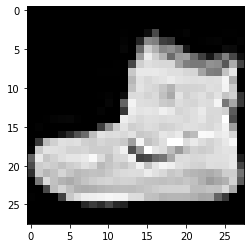

In [23]:
# plot an image!
plt.imshow(data[0].reshape(28, 28), cmap=plt.cm.gray);

### Parsing lvq-pak data files

Recall that we want to create a `parse_function` with the following API: given some input, it returns a triple

```(data, target, additional_metadata)```


where `data` and `target` are in a format ingestible by, say, an sklearn pipeline.
`additional_metadata` is a dictionary of key-value pairs that will be added to any existing metadata.

In [24]:
import pandas as pd
import numpy as np
from functools import partial

In [25]:
def read_space_delimited(filename, skiprows=None, class_labels=True, metadata=None):
    """Read an space-delimited file
    
    Data is space-delimited. Last column is the (string) label for the data

    Note: we can't use automatic comment detection, as `#` characters are also
    used as data labels.

    Parameters
    ----------
    skiprows: list-like, int or callable, optional
        list of rows to skip when reading the file. See `pandas.read_csv`
        entry on `skiprows` for more
    class_labels: boolean
        if true, the last column is treated as the class (target) label
    """
    with open(filename, 'r') as fd:
        df = pd.read_csv(fd, skiprows=skiprows, skip_blank_lines=True,
                           comment=None, header=None, sep=' ', dtype=str)
        # targets are last column. Data is everything else
        if class_labels is True:
            target = df.loc[:, df.columns[-1]].values
            data = df.loc[:, df.columns[:-1]].values
        else:
            data = df.values
            target = np.zeros(data.shape[0])
        return data, target, metadata

**Note:** `read_space_delimited` can be imported from `src.data.utils`.

In [26]:
data, target, metadata = read_space_delimited(datafile_train, skiprows=[0,1])
data.shape, target.shape, metadata

((1962, 20), (1962,), None)

### Exercise: Write a parsing function for F-MNIST

Write a function that takes as input the F-MNIST data path, and returns a (data, target, metadata) triple.

In [27]:
def read_fmnist(data_path, kind='train', metadata=None):
    """
    Read fmnist data files.
    
    Parameters
    ----------
    data_path: path
        base directory to look for the files in
    kind: one of 'train' and 'test'
        whether to parse the training or test datasets
    metadata: dict
        metadata to add to the process
    
    Returns
    -------
    (data, target, metadata)
    """
    data_path = pathlib.Path(data_path)

    if kind == 'train':
        name_kind = kind
    elif kind == 'test':
        name_kind = 't10k'
    else:
        raise ValueError(f"Unknown kind:{kind}")

    # parsing labels aka. target
    with open(data_path / f'{name_kind}-labels-idx1-ubyte', 'rb') as labels:
        target = np.frombuffer(labels.read(), dtype=np.uint8, offset=8)
        
    # parsing images aka. data
    with open(data_path / f'{name_kind}-images-idx3-ubyte', 'rb')as images:
        data = np.frombuffer(images.read(), dtype=np.uint8, offset=16).reshape(len(target), 784)
    
    return data, target, metadata

In [28]:
# test things out
data, target, metadata = read_fmnist(unpack_fmnist, kind='train')
data.shape, target.shape, metadata

((60000, 784), (60000,), None)

In [29]:
data, target, metadata = read_fmnist(unpack_fmnist, kind='test')
data.shape, target.shape, metadata

((10000, 784), (10000,), None)

## Writing a process function

We could be done here, but let's go a little further and allow the parsing function to return either `train`, `test` or `all` data. In other words, let's create a processing function: `process_lvq_pak` that takes a `kind` as input.

In [30]:
def process_lvq_pak(*, unpack_dir, kind='all', extract_dir='lvq_pak-3.1', metadata=None):
    """
    Parse LVQ-PAK datafiles into usable numpy arrays
    
    Parameters
    ----------
    unpack_dir: path
        path to unpacked tarfile
    extract_dir: string
        name of directory in the unpacked tarfile containing
        the raw data files
    kind: {'train', 'test', 'all'}
    
    
    Returns
    -------
    A tuple: 
       (data, target, additional_metadata)
    
    """
    if metadata is None:
        metadata = {}

    if unpack_dir:
        unpack_dir = pathlib.Path(unpack_dir)

    data_dir = unpack_dir / extract_dir

    if kind == 'train':
        data, target, metadata = read_space_delimited(data_dir / 'ex1.dat',
                                                      skiprows=[0,1],
                                                      metadata=metadata)
    elif kind == 'test':
        data, target, metadata = read_space_delimited(data_dir / 'ex2.dat',
                                                      skiprows=[0],
                                                      metadata=metadata)
    elif kind == 'all':
        data1, target1, metadata = read_space_delimited(data_dir / 'ex1.dat', skiprows=[0,1],
                                                        metadata=metadata)
        data2, target2, metadata = read_space_delimited(data_dir / 'ex2.dat', skiprows=[0],
                                                        metadata=metadata)
        data = np.vstack((data1, data2))
        target = np.append(target1, target2)
    else:
        raise Exception(f'Unknown kind: {kind}')

    return data, target, metadata

In [31]:
# All data by default
data, target, metadata = process_lvq_pak(unpack_dir=unpack_dir)
data.shape, target.shape, metadata

((3924, 20), (3924,), {})

In [32]:
# Training data 
data, target, metadata = process_lvq_pak(unpack_dir=unpack_dir, kind='train')
data.shape, target.shape, metadata

((1962, 20), (1962,), {})

In [33]:
# Test data 
data, target, metadata = process_lvq_pak(unpack_dir=unpack_dir, kind='test')
data.shape, target.shape, metadata

((1962, 20), (1962,), {})

Now, by adding `process_lvq_pak` to our `DataSource` object as a `parse_function`, we'll be able to reproducibly create a `Dataset` from our `DataSource`.

In [34]:
dsrc.parse_function = partial(process_lvq_pak, unpack_dir=str(unpack_dir))

In [35]:
dsrc.dataset_opts()

{'dataset_name': 'lvq-pak',
 'metadata': {},
 'data': array([['21.47', '-19.90', '-20.68', ..., '-1.41', '-2.33', '2.12'],
        ['0.05', '28.38', '9.52', ..., '-4.70', '0.30', '0.27'],
        ['-4.71', '-4.61', '-0.64', ..., '2.17', '-0.10', '-0.45'],
        ...,
        ['-2.63', '-6.59', '0.19', ..., '0.76', '0.89', '-3.48'],
        ['5.35', '4.96', '18.75', ..., '-0.57', '0.00', '1.35'],
        ['-0.37', '-5.27', '-1.74', ..., '3.48', '-0.90', '-1.00']],
       dtype=object),
 'target': array(['A', 'I', '#', ..., '#', 'Y', '#'], dtype=object)}

### Exericse: Write a process function for F-MNIST and add it to the `DataSource`

In [36]:
def process_fmnist(*, unpack_dir, kind='all', extract_dir=None, metadata=None):
    """
    Load the F-MNIST dataset

    Parameters
    ----------
    unpack_dir: path
        path to unpacked tarfile
    kind: {'train', 'test', 'all'}
        Dataset comes pre-split into training and test data.
        Indicates which dataset to load
    metadata: dict
        Additional metadata fields will be added to this dict.
        'kind': value of `kind` used to generate a subset of the data
    '''
    
    Returns
    -------
    A tuple: 
       (data, target, additional_metadata)
    
    """
    
    if metadata is None:
        metadata = {}

    if unpack_dir:
        unpack_dir = pathlib.Path(unpack_dir)
    if extract_dir is not None:
        data_dir = unpack_dir / extract_dir
    else:
        data_dir = unpack_dir

    if kind == 'train':
        data, target, metadata = read_fmnist(data_dir, kind='train', metadata=metadata)
    elif kind == 'test':
        data, target, metadata = read_fmnist(data_dir, kind='test', metadata=metadata)
    elif kind == 'all':
        data1, target1, metadata = read_fmnist(data_dir, kind='train', metadata=metadata)
        data2, target2, metadata = read_fmnist(data_dir, kind='test', metadata=metadata)
        data = np.vstack((data1, data2))
        target = np.append(target1, target2)
    else:
        raise Exception(f'Unknown kind: {kind}')

    return data, target, metadata

In [37]:
# test things out
data, target, metadata = process_fmnist(unpack_dir=unpack_fmnist, kind='train')
data.shape, target.shape, metadata

((60000, 784), (60000,), {})

In [38]:
# test things out
data, target, metadata = process_fmnist(unpack_dir=unpack_fmnist, kind='test')
data.shape, target.shape, metadata

((10000, 784), (10000,), {})

In [39]:
# test things out
data, target, metadata = process_fmnist(unpack_dir=unpack_fmnist, kind='all')
data.shape, target.shape, metadata

((70000, 784), (70000,), {})

In [40]:
## Add the process function to the dataset
fmnist.parse_function = partial(process_fmnist, unpack_dir=str(unpack_fmnist))

In [41]:
fmnist.dataset_opts()

{'dataset_name': 'fmnist',
 'metadata': {},
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([9, 0, 0, ..., 8, 1, 5], dtype=uint8)}

### Create a `Dataset`

In [42]:
ds = dsrc.process() # Use the process function to convert this DataSource to a real Dataset
str(ds)

"<Dataset: lvq-pak, data.shape=(3924, 20), target.shape=(3924,), metadata=['descr', 'license', 'dataset_name', 'hash_type', 'data_hash', 'target_hash']>"

In [43]:
print(ds)

<Dataset: lvq-pak, data.shape=(3924, 20), target.shape=(3924,), metadata=['descr', 'license', 'dataset_name', 'hash_type', 'data_hash', 'target_hash']>


In [44]:
ds = dsrc.process(kind="test")  # Should be half the size
print(ds)

<Dataset: lvq-pak, data.shape=(1962, 20), target.shape=(1962,), metadata=['descr', 'license', 'dataset_name', 'hash_type', 'data_hash', 'target_hash']>


In [45]:
type(ds)

src.data.datasets.Dataset

### Write this `DataSource` back into the catalog

In [46]:
# Now we want to save this to the workflow. We can just do the same as before!

In [47]:
workflow.add_datasource(dsrc)

In [48]:
workflow.available_datasources()

['fmnist', 'lvq-pak']

In [49]:
dset_catalog, dset_catalog_file = workflow.available_datasources(keys_only=False)

In [50]:
dset_catalog['lvq-pak']

{'dataset_dir': '/home/amelie/Projects/bus_number_tutorial/data/raw',
 'load_function_args': [],
 'load_function_kwargs': {'unpack_dir': '/home/amelie/Projects/bus_number_tutorial/data/interim/lvq-pak'},
 'load_function_module': '__main__--home-amelie-Projects-bus_number_tutorial-notebooks-__ipython-input__',
 'load_function_name': 'process_lvq_pak',
 'name': 'lvq-pak',
 'url_list': [{'file_name': 'lvq_pak-3.1.tar',
   'hash_type': 'sha1',
   'hash_value': '86024a871724e521341da0ffb783956e39aadb6e',
   'name': None,
   'url': 'http://www.cis.hut.fi/research/lvq_pak/lvq_pak-3.1.tar'},
  {'file_name': 'lvq-pak.readme',
   'hash_type': 'sha1',
   'hash_value': '138b69cc0b4e02950cec5833752e50a54d36fd0f',
   'name': 'DESCR',
   'url': 'http://www.cis.hut.fi/research/lvq_pak/README'},
  {'contents': "\n************************************************************************\n*                                                                      *\n*                              LVQ_PAK      

### Add `parse_lvq_pak` to the `src` module

Part of making things reproducible is moving helper functions out of notebooks and into the `src` module as we go. By convention, we add custom dataset processing and generation function to `src/data/localdata.py`. 

### Exercise: Use the `src` module for reproducibility
Add `process_lvq_pak` to `localdata.py`, (and add it to `__all__`) to make it visible to our dataset code.

In [51]:
%%file ../src/data/localdata.py
"""
Custom dataset processing/generation functions should be added to this file
"""

import pathlib
from .utils import read_space_delimited
import numpy as np

__all__ = [
    'process_lvq_pak'
]


def process_lvq_pak(*, unpack_dir, kind='all', extract_dir='lvq_pak-3.1', metadata=None):
    """
    Parse LVQ-PAK datafiles into usable numpy arrays
    
    Parameters
    ----------
    unpack_dir: path
        path to unpacked tarfile
    extract_dir: string
        name of directory in the unpacked tarfile containing
        the raw data files
    kind: {'train', 'test', 'all'}
    
    
    Returns
    -------
    A tuple: 
       (data, target, additional_metadata)
    
    """
    if metadata is None:
        metadata = {}

    if unpack_dir:
        unpack_dir = pathlib.Path(unpack_dir)

    data_dir = unpack_dir / extract_dir

    if kind == 'train':
        data, target, metadata = read_space_delimited(data_dir / 'ex1.dat',
                                                      skiprows=[0,1],
                                                      metadata=metadata)
    elif kind == 'test':
        data, target, metadata = read_space_delimited(data_dir / 'ex2.dat',
                                                      skiprows=[0],
                                                      metadata=metadata)
    elif kind == 'all':
        data1, target1, metadata = read_space_delimited(data_dir / 'ex1.dat', skiprows=[0,1],
                                                        metadata=metadata)
        data2, target2, metadata = read_space_delimited(data_dir / 'ex2.dat', skiprows=[0],
                                                        metadata=metadata)
        data = np.vstack((data1, data2))
        target = np.append(target1, target2)
    else:
        raise Exception(f'Unknown kind: {kind}')

    return data, target, metadata

Overwriting ../src/data/localdata.py


In [52]:
# This import call should now work!
from src.data.localdata import process_lvq_pak

### Exercise:
Use `process_lvq_pak` from `src.data.localdata` as the `parse_function`, and re-add the `DataSource` to the `workflow`.

In [53]:
dsrc.parse_function = partial(process_lvq_pak, unpack_dir=str(unpack_dir))

In [54]:
workflow.add_datasource(dsrc)

In [55]:
## Should point to the function in the src module, not the function in this notebook!
dset_catalog, dset_catalog_file = workflow.available_datasources(keys_only=False)
dset_catalog['lvq-pak']['load_function_module']

'src.data.localdata'

In [56]:
## Check things still work!
dsrc.process()

{'metadata': {'descr': '************************************************************************\n*                                                                      *\n*                              LVQ_PAK                                 *\n*                                                                      *\n*                                The                                   *\n*                                                                      *\n*                   Learning  Vector  Quantization                     *\n*                                                                      *\n*                          Program  Package                            *\n*                                                                      *\n*                   Version 3.1 (April 7, 1995)                        *\n*                                                                      *\n*                          Prepared by the                             *\n*             

### Exercise: Stop and check everything in using git!

Use a branch, a PR via GitHub or BitBucket, and pull your changes to `src/data/localdata.py` all back into your local master

In [57]:
!git status

Sur la branche master
Votre branche est à jour avec 'origin/master'.

Modifications qui ne seront pas validées :
  (utilisez "git add <fichier>..." pour mettre à jour ce qui sera validé)
  (utilisez "git checkout -- <fichier>..." pour annuler les modifications dans la copie de travail)

	modifié :         ../src/data/localdata.py

aucune modification n'a été ajoutée à la validation (utilisez "git add" ou "git commit -a")


## Exercise: Finish turning the the F-MNIST `DataSource` into a `Dataset`
* save your parse functions in the `src` module
* re-add your datasource to your in the `workflow`

In [58]:
# Add process fmnist to the src module

In [59]:
%%file ../src/data/localdata.py
"""
Custom dataset processing/generation functions should be added to this file
"""

import pathlib
from .utils import read_space_delimited
import numpy as np

__all__ = [
    'process_lvq_pak',
    'process_fmnist'
]


def process_lvq_pak(*, unpack_dir, kind='all', extract_dir='lvq_pak-3.1', metadata=None):
    """
    Parse LVQ-PAK datafiles into usable numpy arrays
    
    Parameters
    ----------
    unpack_dir: path
        path to unpacked tarfile
    extract_dir: string
        name of directory in the unpacked tarfile containing
        the raw data files
    kind: {'train', 'test', 'all'}
    
    
    Returns
    -------
    A tuple: 
       (data, target, additional_metadata)
    
    """
    if metadata is None:
        metadata = {}

    if unpack_dir:
        unpack_dir = pathlib.Path(unpack_dir)

    data_dir = unpack_dir / extract_dir

    if kind == 'train':
        data, target, metadata = read_space_delimited(data_dir / 'ex1.dat',
                                                      skiprows=[0,1],
                                                      metadata=metadata)
    elif kind == 'test':
        data, target, metadata = read_space_delimited(data_dir / 'ex2.dat',
                                                      skiprows=[0],
                                                      metadata=metadata)
    elif kind == 'all':
        data1, target1, metadata = read_space_delimited(data_dir / 'ex1.dat', skiprows=[0,1],
                                                        metadata=metadata)
        data2, target2, metadata = read_space_delimited(data_dir / 'ex2.dat', skiprows=[0],
                                                        metadata=metadata)
        data = np.vstack((data1, data2))
        target = np.append(target1, target2)
    else:
        raise Exception(f'Unknown kind: {kind}')

    return data, target, metadata

def read_fmnist(data_path, kind='train', metadata=None):
    """
    Helper function to read fmnist data files.
    
    Parameters
    ----------
    data_path: path
        base directory to look for the files in
    kind: one of 'train' and 'test'
        whether to parse the training or test datasets
    metadata: dict
        metadata to add to the process
    
    Returns
    -------
    (data, target, metadata)
    """
    data_path = pathlib.Path(data_path)
    
    if kind == 'train':
        name_kind = kind
    elif kind == 'test':
        name_kind = 't10k'
    else:
        raise ValueError(f"Unknown kind:{kind}")

    # parsing labels aka. target
    with open(data_path / f'{name_kind}-labels-idx1-ubyte', 'rb') as labels:
        target = np.frombuffer(labels.read(), dtype=np.uint8, offset=8)
        
    # parsing images aka. data
    with open(data_path / f'{name_kind}-images-idx3-ubyte', 'rb')as images:
        data = np.frombuffer(images.read(), dtype=np.uint8, offset=16).reshape(len(target), 784)
        
    return data, target, metadata

def process_fmnist(*, unpack_dir, kind='all', extract_dir=None, metadata=None):
    """
    Load the F-MNIST dataset 

    Parameters
    ----------
    unpack_dir: path
        path to unpacked tarfile
    kind: {'train', 'test', 'all'}
        Dataset comes pre-split into training and test data.
        Indicates which dataset to load
    metadata: dict
        Additional metadata fields will be added to this dict.
        'kind': value of `kind` used to generate a subset of the data
    '''
    
    Returns
    -------
    A tuple: 
       (data, target, additional_metadata)
    
    """
    if metadata is None:
        metadata = {}

    if unpack_dir:
        unpack_dir = pathlib.Path(unpack_dir)
    if extract_dir is not None:
        data_dir = unpack_dir / extract_dir
    else:
        data_dir = unpack_dir

    if kind == 'train':
        data, target, metadata = read_fmnist(data_dir, kind='train', metadata=metadata)
    elif kind == 'test':
        data, target, metadata = read_fmnist(data_dir, kind='test', metadata=metadata)
    elif kind == 'all':
        data1, target1, metadata = read_fmnist(data_dir, kind='train', metadata=metadata)
        data2, target2, metadata = read_fmnist(data_dir, kind='test', metadata=metadata)
        data = np.vstack((data1, data2))
        target = np.append(target1, target2)
    else:
        raise Exception(f'Unknown kind: {kind}')

    return data, target, metadata

Overwriting ../src/data/localdata.py


In [60]:
from src.data.localdata import process_fmnist

In [61]:
# check that `process_fmnist` is coming from the correct src.data.localdata
process_fmnist?

In [62]:
# Add process_fmnist as a parse function to the fmnist
# DataSource for both train and test (based on the function in src)
fmnist_train = DataSource.from_name('fmnist')
fmnist_train.name = 'fmnist_train'

fmnist_test = DataSource.from_name('fmnist')
fmnist_test.name = 'fmnist_test'

fmnist_train.name, fmnist_test.name, fmnist.name

2019-09-05 10:57:54,491 - utils - ERROR - Invalid parse_function: No module named '__main__--home-amelie-Projects-bus_number_tutorial-notebooks-__ipython-input__'
2019-09-05 10:57:54,493 - utils - ERROR - Invalid parse_function: No module named '__main__--home-amelie-Projects-bus_number_tutorial-notebooks-__ipython-input__'


('fmnist_train', 'fmnist_test', 'fmnist')

In [63]:
fmnist.parse_function  = partial(process_fmnist, unpack_dir=str(fmnist_unpack_dir))

NameError: name 'fmnist_unpack_dir' is not defined

In [64]:
# test things out
fmnist_dataset = fmnist.process(kind='train')
fmnist_dataset.data.shape, fmnist_dataset.target.shape,

((60000, 784), (60000,))

In [65]:
fmnist_dataset = fmnist.process(kind='test')
fmnist_dataset.data.shape, fmnist_dataset.target.shape,

((10000, 784), (10000,))

In [66]:
fmnist_dataset = fmnist.process()
fmnist_dataset.data.shape, fmnist_dataset.target.shape,

((70000, 784), (70000,))

In [67]:
# Add the fmnist DataSource to the workflow

In [68]:
workflow.add_datasource(fmnist)

In [69]:
workflow.available_datasources()

['fmnist', 'lvq-pak']

In [70]:
# Check that the fmnist DataSource `load_function_name` is pointing to the `src` module
dset_catalog, dset_catalog_file = workflow.available_datasources(keys_only=False)
dset_catalog['fmnist']['load_function_module'], dset_catalog['fmnist']['load_function_name']

('__main__--home-amelie-Projects-bus_number_tutorial-notebooks-__ipython-input__',
 'process_fmnist')

In [71]:
# Check everything in using git
!git status

Sur la branche master
Votre branche est à jour avec 'origin/master'.

rien à valider, la copie de travail est propre


## Automating the workflow

What we have so far is enough to be able to load a `Dataset` from a `DataSource`. We want to go a step further and add the generation of this data to the automated workflow so that we can blow away our data and recreate it using `make` commands.

Next up, we want to be able to `make data`:
<img src="references/cheat_sheet.png" alt="Reproducible Data Science Workflow" width="400"/>


In [72]:
from src.data import Dataset

In [73]:
workflow.available_datasources()

['fmnist', 'lvq-pak']

In [74]:
lvq_pak = Dataset.from_datasource('lvq-pak')

In [75]:
str(lvq_pak)

"<Dataset: lvq-pak, data.shape=(3924, 20), target.shape=(3924,), metadata=['descr', 'license', 'dataset_name', 'hash_type', 'data_hash', 'target_hash']>"

## Recall: so far we have up to `make sources`

In [76]:
!cd .. && make clean_raw && make clean_interim

rm -f data/raw/*
rm -rf data/interim/*


In [77]:
!cd .. && make sources

python3 -m src.data.make_dataset process
2019-09-05 10:57:58,774 - utils - ERROR - Invalid parse_function: No module named '__main__--home-amelie-Projects-bus_number_tutorial-notebooks-__ipython-input__'
2019-09-05 10:57:58,775 - datasets - INFO - Running process on fmnist
2019-09-05 10:58:04,373 - utils - WARNING - Default process_fmnist: Add parse function to generate `data` or `target`
Traceback (most recent call last):
  File "/home/amelie/miniconda3/envs/bus_number_tutorial/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/amelie/miniconda3/envs/bus_number_tutorial/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/amelie/Projects/bus_number_tutorial/src/data/make_dataset.py", line 32, in <module>
    main()
  File "/home/amelie/miniconda3/envs/bus_number_tutorial/lib/python3.7/site-packages/click/core.py", line 764, in __call__
    return self.main(*args, **kwargs)
  File "/home/amelie/miniconda

And we can recover our newly created `Datasets` from our `DataSources`

In [78]:
ds = Dataset.from_datasource('lvq-pak')
ds.data.shape, ds.target.shape

((3924, 20), (3924,))

In [79]:
ds = Dataset.from_datasource('lvq-pak', kind='train')
ds.data.shape, ds.target.shape

((1962, 20), (1962,))

## Transformers: an intro to `make data`

We still need to automate our the `Dataset` generation as part of our `workflow`. We'll do this using `transformers` (which we'll get into more in the next notebook)

In [80]:
!ls -la $paths.data_path/processed

total 896
drwxrwxr-x 2 amelie amelie   4096 août  30 17:38 .
drwxrwxr-x 5 amelie amelie   4096 août  30 17:37 ..
-rw-rw-r-- 1 amelie amelie   2569 août  30 17:38 fmnist_test.dataset
-rw-rw-r-- 1 amelie amelie   2493 août  30 17:38 fmnist_test.metadata
-rw-rw-r-- 1 amelie amelie   2570 août  30 17:38 fmnist_train.dataset
-rw-rw-r-- 1 amelie amelie   2494 août  30 17:38 fmnist_train.metadata
-rw-rw-r-- 1 amelie amelie 881920 août  30 17:38 lvq-pak.dataset
-rw-rw-r-- 1 amelie amelie   7677 août  30 17:38 lvq-pak.metadata


In [81]:
ds.dump()

In [82]:
!ls -la $paths.data_path/processed

total 472
drwxrwxr-x 2 amelie amelie   4096 août  30 17:38 .
drwxrwxr-x 5 amelie amelie   4096 août  30 17:37 ..
-rw-rw-r-- 1 amelie amelie   2569 août  30 17:38 fmnist_test.dataset
-rw-rw-r-- 1 amelie amelie   2493 août  30 17:38 fmnist_test.metadata
-rw-rw-r-- 1 amelie amelie   2570 août  30 17:38 fmnist_train.dataset
-rw-rw-r-- 1 amelie amelie   2494 août  30 17:38 fmnist_train.metadata
-rw-rw-r-- 1 amelie amelie 446736 sept.  5 10:58 lvq-pak.dataset
-rw-rw-r-- 1 amelie amelie   7677 sept.  5 10:58 lvq-pak.metadata


In [83]:
!cd .. && make clean_processed

rm -f data/processed/*


In [84]:
!ls -la $paths.data_path/processed

total 8
drwxrwxr-x 2 amelie amelie 4096 sept.  5 10:58 .
drwxrwxr-x 5 amelie amelie 4096 août  30 17:37 ..



Let's encode this as a transformer from a `DataSource` to a `Dataset` as part of our automated, reproducible workflow!

In [85]:
workflow.add_transformer(from_datasource='lvq-pak')

In [86]:
workflow.get_transformer_list()

[{'datasource_name': 'lvq-pak', 'output_dataset': 'lvq-pak'},
 {'datasource_name': 'fmnist',
  'datasource_opts': {'kind': 'train'},
  'output_dataset': 'fmnist_train'},
 {'datasource_name': 'fmnist',
  'datasource_opts': {'kind': 'test'},
  'output_dataset': 'fmnist_test'},
 {'datasource_name': 'lvq-pak', 'output_dataset': 'lvq-pak'}]

In [87]:
workflow.make_data()

2019-09-05 10:58:07,854 - transform_data - INFO - Writing transformed Dataset: lvq-pak
2019-09-05 10:58:08,074 - utils - ERROR - Invalid parse_function: No module named '__main__--home-amelie-Projects-bus_number_tutorial-notebooks-__ipython-input__'
2019-09-05 10:58:08,845 - utils - WARNING - Default process_fmnist: Add parse function to generate `data` or `target`
2019-09-05 10:58:08,849 - transform_data - INFO - Writing transformed Dataset: fmnist_train
2019-09-05 10:58:08,852 - utils - ERROR - Invalid parse_function: No module named '__main__--home-amelie-Projects-bus_number_tutorial-notebooks-__ipython-input__'
2019-09-05 10:58:09,636 - utils - WARNING - Default process_fmnist: Add parse function to generate `data` or `target`
2019-09-05 10:58:09,639 - transform_data - INFO - Writing transformed Dataset: fmnist_test
2019-09-05 10:58:09,714 - transform_data - INFO - Writing transformed Dataset: lvq-pak


In [88]:
!ls -la $paths.data_path/processed

total 896
drwxrwxr-x 2 amelie amelie   4096 sept.  5 10:58 .
drwxrwxr-x 5 amelie amelie   4096 août  30 17:37 ..
-rw-rw-r-- 1 amelie amelie   2569 sept.  5 10:58 fmnist_test.dataset
-rw-rw-r-- 1 amelie amelie   2493 sept.  5 10:58 fmnist_test.metadata
-rw-rw-r-- 1 amelie amelie   2570 sept.  5 10:58 fmnist_train.dataset
-rw-rw-r-- 1 amelie amelie   2494 sept.  5 10:58 fmnist_train.metadata
-rw-rw-r-- 1 amelie amelie 881920 sept.  5 10:58 lvq-pak.dataset
-rw-rw-r-- 1 amelie amelie   7677 sept.  5 10:58 lvq-pak.metadata


In [89]:
!cd .. && make clean_processed

rm -f data/processed/*


In [90]:
!cd .. && make data

python3 -m src.data.apply_transforms
2019-09-05 10:58:11,032 - apply_transforms - INFO - Transforming datasets from transformer_list.json
2019-09-05 10:58:11,054 - transform_data - INFO - Writing transformed Dataset: lvq-pak
2019-09-05 10:58:11,281 - utils - ERROR - Invalid parse_function: No module named '__main__--home-amelie-Projects-bus_number_tutorial-notebooks-__ipython-input__'
2019-09-05 10:58:12,005 - transform_data - INFO - Writing transformed Dataset: fmnist_train
2019-09-05 10:58:12,006 - utils - ERROR - Invalid parse_function: No module named '__main__--home-amelie-Projects-bus_number_tutorial-notebooks-__ipython-input__'
2019-09-05 10:58:12,739 - transform_data - INFO - Writing transformed Dataset: fmnist_test
2019-09-05 10:58:12,818 - transform_data - INFO - Writing transformed Dataset: lvq-pak


In [91]:
!ls -la $paths.data_path/processed

total 896
drwxrwxr-x 2 amelie amelie   4096 sept.  5 10:58 .
drwxrwxr-x 5 amelie amelie   4096 août  30 17:37 ..
-rw-rw-r-- 1 amelie amelie   2569 sept.  5 10:58 fmnist_test.dataset
-rw-rw-r-- 1 amelie amelie   2493 sept.  5 10:58 fmnist_test.metadata
-rw-rw-r-- 1 amelie amelie   2570 sept.  5 10:58 fmnist_train.dataset
-rw-rw-r-- 1 amelie amelie   2494 sept.  5 10:58 fmnist_train.metadata
-rw-rw-r-- 1 amelie amelie 881920 sept.  5 10:58 lvq-pak.dataset
-rw-rw-r-- 1 amelie amelie   7677 sept.  5 10:58 lvq-pak.metadata


## Exercise: Create the F-MNIST dataset

* Create an F-MNIST `Dataset`
* Blow it away and recreate it using `make data`

In [92]:
workflow.add_transformer(from_datasource='fmnist',
                         datasource_opts={'kind':'train'},
                         output_dataset='fmnist_train')

In [93]:
workflow.add_transformer(from_datasource='fmnist',
                         datasource_opts={'kind':'test'},
                         output_dataset='fmnist_test')

In [94]:
workflow.make_data()

2019-09-05 10:58:13,639 - transform_data - INFO - Writing transformed Dataset: lvq-pak
2019-09-05 10:58:13,856 - utils - ERROR - Invalid parse_function: No module named '__main__--home-amelie-Projects-bus_number_tutorial-notebooks-__ipython-input__'
2019-09-05 10:58:14,622 - transform_data - INFO - Writing transformed Dataset: fmnist_train
2019-09-05 10:58:14,624 - utils - ERROR - Invalid parse_function: No module named '__main__--home-amelie-Projects-bus_number_tutorial-notebooks-__ipython-input__'
2019-09-05 10:58:15,348 - transform_data - INFO - Writing transformed Dataset: fmnist_test
2019-09-05 10:58:15,468 - transform_data - INFO - Writing transformed Dataset: lvq-pak
2019-09-05 10:58:15,691 - utils - ERROR - Invalid parse_function: No module named '__main__--home-amelie-Projects-bus_number_tutorial-notebooks-__ipython-input__'
2019-09-05 10:58:16,458 - transform_data - INFO - Writing transformed Dataset: fmnist_train
2019-09-05 10:58:16,471 - utils - ERROR - Invalid parse_functi

In [95]:
workflow.available_datasets()

['fmnist_test', 'lvq-pak', 'fmnist_train']

In [96]:
ds = Dataset.load('fmnist_train')
ds.data.shape, ds.target.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [97]:
ds = Dataset.load('fmnist_test')
ds.data.shape, ds.target.shape

AttributeError: 'NoneType' object has no attribute 'shape'

## Welcome to Reproducible Datasets!